# Transfer learning with BERT as a base model

In [ ]:
# !pip install transformers

In [33]:
# import required libraries
import pandas as pd
import numpy as np
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

from transformers import AutoTokenizer
from transformers import TFAutoModelForSequenceClassification # for sentimental analysis

### Load Amazon Reviews Dataset

In [34]:
amazon_reviews_df = pd.read_csv('/kaggle/input/amazon/cleaned_amazon_reviews.csv')

In [35]:
amazon_reviews_df.head()

,sentiments,cleaned_review,cleaned_review_length,review_score
0,positive,i wish would have gotten one earlier love it a...,19,5.0
1,neutral,i ve learned this lesson again open the packag...,88,1.0
2,neutral,it is so slow and lags find better option,9,2.0
3,neutral,roller ball stopped working within months of m...,12,1.0
4,neutral,i like the color and size but it few days out ...,21,1.0


In [36]:
amazon_reviews_df.describe()

,cleaned_review_length,review_score
count,17340.000000,17340.000000
mean,30.300461,3.649077
std,35.836540,1.673500
min,0.000000,1.000000
25%,9.000000,2.000000
50%,20.000000,5.000000
75%,38.000000,5.000000
max,571.000000,5.000000


In [37]:
amazon_reviews_df.shape

(17340, 4)

In [38]:
amazon_reviews_df.isna().sum()

sentiments               0
cleaned_review           3
cleaned_review_length    0
review_score             0
dtype: int64

-> It has missing values

<AxesSubplot:>

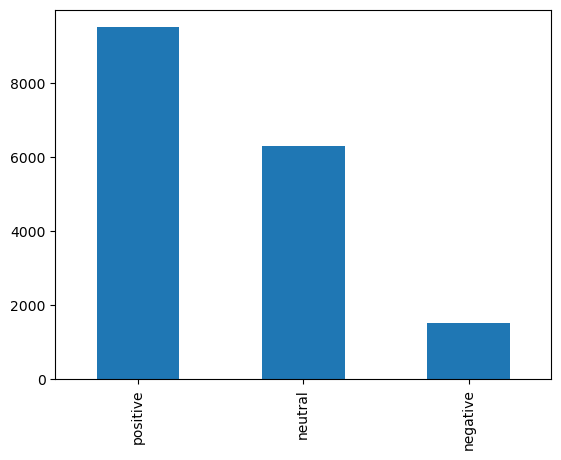

In [39]:
amazon_reviews_df.sentiments.value_counts().plot(kind='bar')

-> Imbalanced dataset

### Data Preprocessing

In [40]:
# remove not needed columns
amazon_reviews_df.drop(columns=["cleaned_review_length", "review_score"], inplace=True)

In [41]:
# remove NaN values
amazon_reviews_df.dropna(inplace=True)

In [42]:
X_amazon_reviews = amazon_reviews_df.drop(columns=['sentiments'])
y_amazon_reviews = amazon_reviews_df['sentiments']

# encode target class
le = LabelEncoder()
y_amazon_reviews_labels = le.fit_transform(y_amazon_reviews)
# apply one-hot-encoding
y_amazon_reviews = to_categorical(y_amazon_reviews_labels)

In [43]:
# split train-test 80-20
X_train_reviews, X_test_reviews, y_train_reviews, y_test_reviews = train_test_split(X_amazon_reviews,
                                                                                    y_amazon_reviews,
                                                                                    random_state=42,
                                                                                    test_size=0.2)

In [44]:
# split train-validation 80-20
X_train_reviews, X_valid_reviews, y_train_reviews, y_valid_reviews = train_test_split(X_train_reviews,
                                                                                      y_train_reviews,
                                                                                      random_state=42,
                                                                                      test_size=0.2)

### Data preparation for BERT model structure

In [45]:
model_name = "bert-base-uncased"

# load tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [46]:
# apply tokenizer or our dataset
train_encodings = tokenizer(list(X_train_reviews['cleaned_review']),
                            truncation=True,
                            padding="max_length",
                            return_tensors="np",
                            return_token_type_ids=False)
valid_encodings = tokenizer(list(X_valid_reviews['cleaned_review']),
                            truncation=True,
                            padding="max_length",
                            return_tensors="np",
                            return_token_type_ids=False)
test_encodings = tokenizer(list(X_test_reviews['cleaned_review']),
                           truncation=True,
                           padding="max_length",
                           return_tensors="np",
                           return_token_type_ids=False)

In [47]:
# prepare tensor dataset that can be used for model training
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    y_train_reviews
))

valid_dataset = tf.data.Dataset.from_tensor_slices((
    dict(valid_encodings),
    y_valid_reviews
))

test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    y_test_reviews
))

In [48]:
batch_size = 8

train_dataset = train_dataset.shuffle(1000).batch(batch_size, drop_remainder=True)
valid_dataset = valid_dataset.shuffle(1000).batch(batch_size, drop_remainder=True)
test_dataset = test_dataset.shuffle(1000).batch(batch_size, drop_remainder=True)

In [49]:
seq_num = train_dataset.take(1).element_spec[0]['input_ids'].shape[1]

## BERT Model Development

### Hyperparamater Tuning

In [21]:
learning_rates = [0.00002, 0.00003]
input_activation = ['sigmoid']
epsilon = [1e-08, 1e-07]

for act in input_activation:
    for eps in epsilon:
        for lr in learning_rates:
            model = TFAutoModelForSequenceClassification.from_pretrained(model_name)
            input_ids = tf.keras.layers.Input(shape=(seq_num,), name='input_ids', dtype='int32')
            attention_mask = tf.keras.layers.Input(shape=(seq_num,), name='attention_mask', dtype='int32')

            embeddings = model.bert(input_ids, attention_mask)[1]

            x = tf.keras.layers.Dense(seq_num * 2, activation=act)(embeddings)
            y = tf.keras.layers.Dense(len(y_amazon_reviews[0]), activation='softmax', name='outputs')(x)

            model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=y)

            model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr, epsilon=eps), 
                          loss=tf.keras.losses.CategoricalCrossentropy(), 
                          metrics=[tf.keras.metrics.CategoricalAccuracy('accuracy')])
            print("lr: ", lr)
            print("activation: ", act)
            print("epsilon: ", eps)
            model.fit(train_dataset, validation_data=valid_dataset, epochs=3)

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


lr:  2e-05
activation:  sigmoid
epsilon:  1e-08
Epoch 1/3
1161/1161 [==============================] - 755s 643ms/step - loss: 0.4425 - accuracy: 0.8168 - val_loss: 0.3012 - val_accuracy: 0.8811
Epoch 2/3
1161/1161 [==============================] - 744s 641ms/step - loss: 0.2125 - accuracy: 0.9166 - val_loss: 0.2675 - val_accuracy: 0.9049
Epoch 3/3
1161/1161 [==============================] - 744s 641ms/step - loss: 0.1130 - accuracy: 0.9588 - val_loss: 0.3058 - val_accuracy: 0.8964


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


lr:  3e-05
activation:  sigmoid
epsilon:  1e-08
Epoch 1/3
1161/1161 [==============================] - 755s 642ms/step - loss: 0.4213 - accuracy: 0.8205 - val_loss: 0.2894 - val_accuracy: 0.8789
Epoch 2/3
1161/1161 [==============================] - 743s 640ms/step - loss: 0.2122 - accuracy: 0.9123 - val_loss: 0.2521 - val_accuracy: 0.8999
Epoch 3/3
1161/1161 [==============================] - 743s 640ms/step - loss: 0.1166 - accuracy: 0.9537 - val_loss: 0.3015 - val_accuracy: 0.8907


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


lr:  2e-05
activation:  sigmoid
epsilon:  1e-07
Epoch 1/3
1161/1161 [==============================] - 755s 642ms/step - loss: 0.4408 - accuracy: 0.8129 - val_loss: 0.2846 - val_accuracy: 0.8853
Epoch 2/3
1161/1161 [==============================] - 744s 641ms/step - loss: 0.2015 - accuracy: 0.9213 - val_loss: 0.2824 - val_accuracy: 0.9025
Epoch 3/3
1161/1161 [==============================] - 744s 640ms/step - loss: 0.1029 - accuracy: 0.9619 - val_loss: 0.3314 - val_accuracy: 0.9032


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


lr:  3e-05
activation:  sigmoid
epsilon:  1e-07
Epoch 1/3
1161/1161 [==============================] - 755s 642ms/step - loss: 0.4331 - accuracy: 0.8169 - val_loss: 0.3095 - val_accuracy: 0.8750
Epoch 2/3
1161/1161 [==============================] - 744s 641ms/step - loss: 0.2064 - accuracy: 0.9184 - val_loss: 0.3044 - val_accuracy: 0.8949
Epoch 3/3
1161/1161 [==============================] - 744s 641ms/step - loss: 0.1235 - accuracy: 0.9521 - val_loss: 0.2867 - val_accuracy: 0.9019


lr:  1e-05

activation:  sigmoid

epsilon:  1e-08

Epoch 1/3
1161/1161 [==============================] - 754s 642ms/step - loss: 0.4631 - accuracy: 0.8053 - val_loss: 0.3493 - val_accuracy: 0.8422

Epoch 2/3
1161/1161 [==============================] - 744s 641ms/step - loss: 0.2282 - accuracy: 0.9081 - val_loss: 0.2723 - val_accuracy: 0.8881

Epoch 3/3
1161/1161 [==============================] - 744s 641ms/step - loss: 0.1226 - accuracy: 0.9543 - val_loss: 0.2892 - val_accuracy: 0.8984

lr:  1e-05

activation:  sigmoid

epsilon:  1e-07

Epoch 1/3
1161/1161 [==============================] - 797s 678ms/step - loss: 0.4817 - accuracy: 0.8000 - val_loss: 0.3282 - val_accuracy: 0.8610

Epoch 2/3
1161/1161 [==============================] - 785s 676ms/step - loss: 0.2470 - accuracy: 0.9014 - val_loss: 0.3651 - val_accuracy: 0.8542

Epoch 3/3
1161/1161 [==============================] - 744s 641ms/step - loss: 0.1358 - accuracy: 0.9488 - val_loss: 0.3326 - val_accuracy: 0.8925

lr:  0.0001

activation:  sigmoid

epsilon:  1e-07

Epoch 1/3
1161/1161 [==============================] - 755s 642ms/step - loss: 0.7267 - accuracy: 0.7011 - val_loss: 0.8825 - val_accuracy: 0.5870

Epoch 2/3
1161/1161 [==============================] - 744s 641ms/step - loss: 0.9163 - accuracy: 0.5415 - val_loss: 0.9208 - val_accuracy: 0.5553

Epoch 3/3
1161/1161 [==============================] - 744s 641ms/step - loss: 0.9286 - accuracy: 0.5250 - val_loss: 0.9214 - val_accuracy: 0.5555

lr:  2e-05
activation:  sigmoid
epsilon:  1e-08
Epoch 1/3
1161/1161 [==============================] - 755s 643ms/step - loss: 0.4425 - accuracy: 0.8168 - val_loss: 0.3012 - val_accuracy: 0.8811

Epoch 2/3
1161/1161 [==============================] - 744s 641ms/step - loss: 0.2125 - accuracy: 0.9166 - val_loss: 0.2675 - val_accuracy: 0.9049

Epoch 3/3
1161/1161 [==============================] - 744s 641ms/step - loss: 0.1130 - accuracy: 0.9588 - val_loss: 0.3058 - val_accuracy: 0.8964




lr:  3e-05
    
activation:  sigmoid
    
epsilon:  1e-08

Epoch 1/3
1161/1161 [==============================] - 755s 642ms/step - loss: 0.4213 - accuracy: 0.8205 - val_loss: 0.2894 - val_accuracy: 0.8789

Epoch 2/3
1161/1161 [==============================] - 743s 640ms/step - loss: 0.2122 - accuracy: 0.9123 - val_loss: 0.2521 - val_accuracy: 0.8999

Epoch 3/3
1161/1161 [==============================] - 743s 640ms/step - loss: 0.1166 - accuracy: 0.9537 - val_loss: 0.3015 - val_accuracy: 0.8907

lr:  2e-05

activation:  sigmoid

epsilon:  1e-07

Epoch 1/3
1161/1161 [==============================] - 755s 642ms/step - loss: 0.4408 - accuracy: 0.8129 - val_loss: 0.2846 - val_accuracy: 0.8853

Epoch 2/3
1161/1161 [==============================] - 744s 641ms/step - loss: 0.2015 - accuracy: 0.9213 - val_loss: 0.2824 - val_accuracy: 0.9025

Epoch 3/3
1161/1161 [==============================] - 744s 640ms/step - loss: 0.1029 - accuracy: 0.9619 - val_loss: 0.3314 - val_accuracy: 0.9032

lr:  3e-05

activation:  sigmoid

epsilon:  1e-07

Epoch 1/3
1161/1161 [==============================] - 755s 642ms/step - loss: 0.4331 - accuracy: 0.8169 - val_loss: 0.3095 - val_accuracy: 0.8750

Epoch 2/3
1161/1161 [==============================] - 744s 641ms/step - loss: 0.2064 - accuracy: 0.9184 - val_loss: 0.3044 - val_accuracy: 0.8949

Epoch 3/3
1161/1161 [==============================] - 744s 641ms/step - loss: 0.1235 - accuracy: 0.9521 - val_loss: 0.2867 - val_accuracy: 0.9019

### Model Development using best params

In [50]:
# load pretrained model
model = TFAutoModelForSequenceClassification.from_pretrained(model_name)

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [51]:
# embedd input and output layers for model
input_ids = tf.keras.layers.Input(shape=(seq_num,), name='input_ids', dtype='int32')
attention_mask = tf.keras.layers.Input(shape=(seq_num,), name='attention_mask', dtype='int32')

embeddings = model.bert(input_ids, attention_mask)[1]

x = tf.keras.layers.Dense(seq_num * 2, activation='relu')(embeddings)
y = tf.keras.layers.Dense(len(y_amazon_reviews[0]), activation='softmax', name='outputs')(x)

In [52]:
# build new model structure
model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=y)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 512)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 512)]        0           []                               
                                                                                                  
 bert (TFBertMainLayer)         TFBaseModelOutputWi  109482240   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 512,                                         

In [53]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-05, epsilon=1e-07), 
              loss=tf.keras.losses.CategoricalCrossentropy(), 
              metrics=[tf.keras.metrics.CategoricalAccuracy('accuracy')])

#### Training model (requires a lot of time) - Can be skipped

In [54]:
model.fit(train_dataset, validation_data=valid_dataset, epochs=3)

Epoch 1/3
1386/1386 [==============================] - 836s 596ms/step - loss: 0.4189 - accuracy: 0.8200 - val_loss: 0.2828 - val_accuracy: 0.8848
Epoch 2/3
1386/1386 [==============================] - 824s 595ms/step - loss: 0.1973 - accuracy: 0.9237 - val_loss: 0.2894 - val_accuracy: 0.8970
Epoch 3/3
1386/1386 [==============================] - 824s 595ms/step - loss: 0.1088 - accuracy: 0.9616 - val_loss: 0.2508 - val_accuracy: 0.9118


In [55]:
# save model to be able to load later
model.save('bert-amazon-model')

#### Load saved model to skip training

In [1]:
saved_model = tf.keras.models.load_model('models/bert-amazon-model')

NameError: name 'tf' is not defined

In [ ]:
saved_model.evaluate(test_dataset)

#### Evaluate model on test data

In [ ]:
y_pred = model.predict(test_dataset)

In [56]:
model.evaluate(test_dataset)

433/433 [==============================] - 77s 178ms/step - loss: 0.2613 - accuracy: 0.9189


[0.26130756735801697, 0.9188799262046814]